In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from math import sqrt 
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.api import Holt

# Acquire and Prepare Data

In [2]:
# acquire data from local csv
climate_df=pd.read_csv('GlobalLandTemperaturesByState.csv')

In [3]:
# review the info about the dataframe
climate_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645675 entries, 0 to 645674
Data columns (total 5 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   dt                             645675 non-null  object 
 1   AverageTemperature             620027 non-null  float64
 2   AverageTemperatureUncertainty  620027 non-null  float64
 3   State                          645675 non-null  object 
 4   Country                        645675 non-null  object 
dtypes: float64(2), object(3)
memory usage: 24.6+ MB


In [4]:
# set the dt column to datetime format
climate_df['dt']=pd.to_datetime(climate_df['dt'])

In [5]:
# set date as index
climate_df=climate_df.set_index('dt')

In [6]:
climate_df=climate_df.drop(columns=['AverageTemperatureUncertainty'])

In [7]:
# getting value counts for general information
climate_df.Country.value_counts()

Russia           254972
United States    149745
India             86664
China             68506
Canada            35358
Brazil            34328
Australia         16102
Name: Country, dtype: int64

In [8]:
# sort the index values
climate_df.index.sort_values()

DatetimeIndex(['1743-11-01', '1743-11-01', '1743-11-01', '1743-11-01',
               '1743-11-01', '1743-11-01', '1743-11-01', '1743-11-01',
               '1743-11-01', '1743-11-01',
               ...
               '2013-09-01', '2013-09-01', '2013-09-01', '2013-09-01',
               '2013-09-01', '2013-09-01', '2013-09-01', '2013-09-01',
               '2013-09-01', '2013-09-01'],
              dtype='datetime64[ns]', name='dt', length=645675, freq=None)

In [9]:
# convert the temperature to Fahrenheit and sort the dat values
climate_df.AverageTemperature=(climate_df.AverageTemperature*9/5)+32
climate_df=climate_df.dropna()

In [10]:
# drop country and state columns due to we will only explore New York
climate_df=climate_df[climate_df.State=='New York'].drop(columns=['Country','State'])

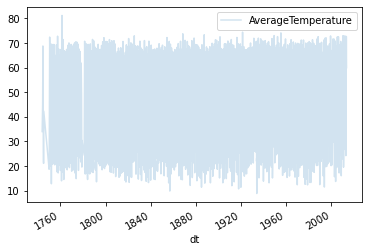

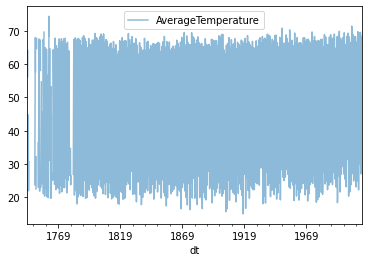

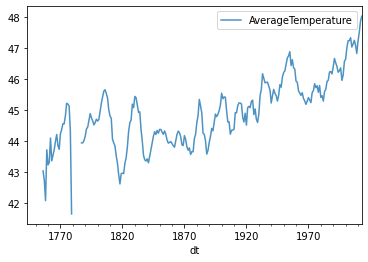

In [11]:
# check daily
climate_df.plot(alpha=.2, label='day')
# Check the month over month average
climate_df.resample('M').mean().rolling(3).mean().plot(alpha=.5, label='Monthly')
# check year over year
# it seems like global is getting warmer year over year
climate_df.resample('Y').mean().rolling(7).mean().plot(alpha=.8, label='Yearly')
plt.legend()

## Key Takeaway So far
- There are missing value from 1770 to around 1800
- Due to large years range, the data will collected from 1800 after

In [12]:
# set condition for index
climate_df=climate_df[climate_df.index>='1800']

In [13]:
# split to train, validate and test
train_size = int(len(climate_df.AverageTemperature) * .5)
validate_size = int(len(climate_df.AverageTemperature) * .3)
test_size = int(len(climate_df.AverageTemperature) - train_size - validate_size)
validate_end_index = train_size + validate_size
train = climate_df[: train_size]
validate = climate_df[train_size : validate_end_index]
test = climate_df[validate_end_index : ]
frames = [train,validate]
trainv = pd.concat(frames)

##  Wrangle Key Takeaway
- There are over 8 billion datas from all around the world
- we have over 159 countries represented here
- we would able to reduced it to New York state, and 3119 datasets
- The nulls were dropped
- Split data into train, validate, and test by percentage
- set the date into index

# Exploration

<AxesSubplot:ylabel='Frequency'>

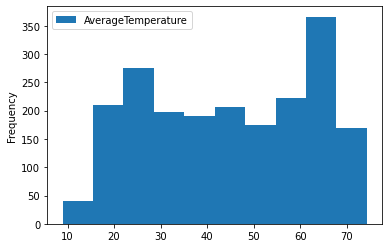

In [14]:
# check training hist
trainv.plot.hist()

[Text(0.5, 1.0, 'Average Temperature by Month'),
 Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Temp (F)')]

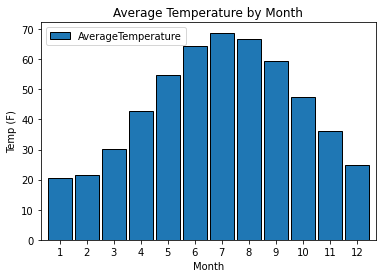

In [15]:
# plot the month to check out average temperature around the world
ax = trainv.groupby(trainv.index.month).mean().plot.bar(width=.9, ec='black')
plt.xticks(rotation=0)
ax.set(title='Average Temperature by Month', xlabel='Month', ylabel='Temp (F)')

<AxesSubplot:title={'center':'Average Month-to-Month change in temperature'}, xlabel='dt'>

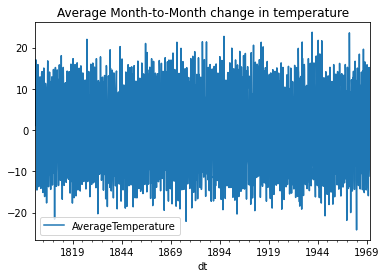

In [16]:
# check month over month average change in temperature
trainv.resample('M').mean().diff().plot(title='Average Month-to-Month change in temperature')

<AxesSubplot:xlabel='dt'>

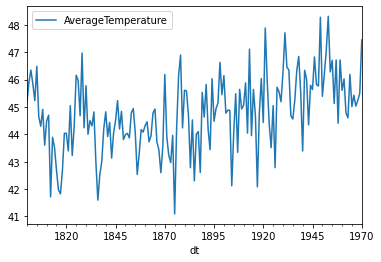

In [17]:
trainv.resample('Y').mean().plot(label='Yearly')

# Exploration Key Takeaway so far
- The year is increasing since 1900
- The monthly view is not significantly able to identify what happened thru put the time
- The month average showed that June to September are highest temperature
- Next we are going to start a hypothesis test on whether the year after 1870 is hotter than year before 1970

## Question 1: Wether the year after 1870 is hotter than year before 1870

- H0: Mean of monthly average temperture after 1870 <= Mean of monthly average temperture before 1870
- Ha: Mean of monthly average temperture after 1870 > Mean of monthly average temperture before 1870

In [18]:
alpha = .05
before = trainv[trainv.index<='1870'].AverageTemperature
after = trainv[trainv.index>'1870'].AverageTemperature.mean()
t, p = stats.ttest_1samp(before, after)
print(t, p/2, alpha)

-1.7418125787551728 0.040953642646682595 0.05


In [19]:
if p/2 > alpha:
    print("The year after 1870 is hotter than the year before 1870")
elif t < 0:
    print("The year after 1870 is hotter than year before 1870")
else:
    print("We reject the year after 1870 is hotter than year before 1870")

The year after 1870 is hotter than year before 1870


#### Question 1 TakeAway
- The year after 1850 is hotter thant the year before
- The global temperature is getting hotter
- It might be the other assumption to make, the earth is under cycle. so next step is going to take the other test 

## Question 2: Wether the year after 1950 is hotter than year before 1950

- H0: Mean of monthly average temperture after 1950 <= Mean of monthly average temperture before 1950
- Ha: Mean of monthly average temperture after 1950 > Mean of monthly average temperture before 1950

In [20]:
alpha = .05
before = trainv[trainv.index<='1950'].AverageTemperature
after = trainv[trainv.index>'1950'].AverageTemperature.mean()
t, p = stats.ttest_1samp(before, after)
print(t, p/2, alpha)

-3.253546377013181 0.0005804285425598146 0.05


In [21]:
if p/2 > alpha:
    print("The year after 1950 is hotter than the year before 1950")
elif t < 0:
    print("The year after 1950 is hotter than year before 1950")
else:
    print("We reject the year after 1950 is hotter than year before 1950")

The year after 1950 is hotter than year before 1950


#### Question 1 TakeAway
- The year after 1950 is hotter thant the year before
- The global temperature is getting hotter
- We can assumed there are no biased info in this dataset, the result revealed that the world is getting hotter every year since 1850 

Text(0.5, 1.0, 'Lag plot with lag=1')

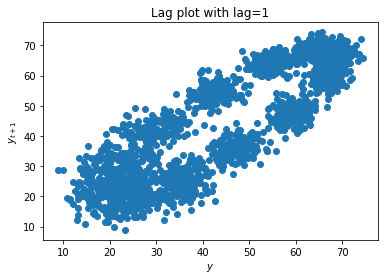

In [22]:
# check out lag plot
plt.scatter(trainv, trainv.shift(-1))
plt.xlabel('$y$')
plt.ylabel('$y_{t + 1}$')
plt.title('Lag plot with lag=1')

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

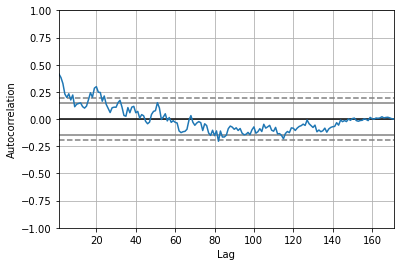

In [23]:
pd.plotting.autocorrelation_plot(trainv.AverageTemperature.resample('Y').mean())

## Exploration Key Take Away
- The world is getting hotter every year since 1820.
- The global is getting warmer and warmer
- The lag revealed there are potential cooling down on the temperature rising

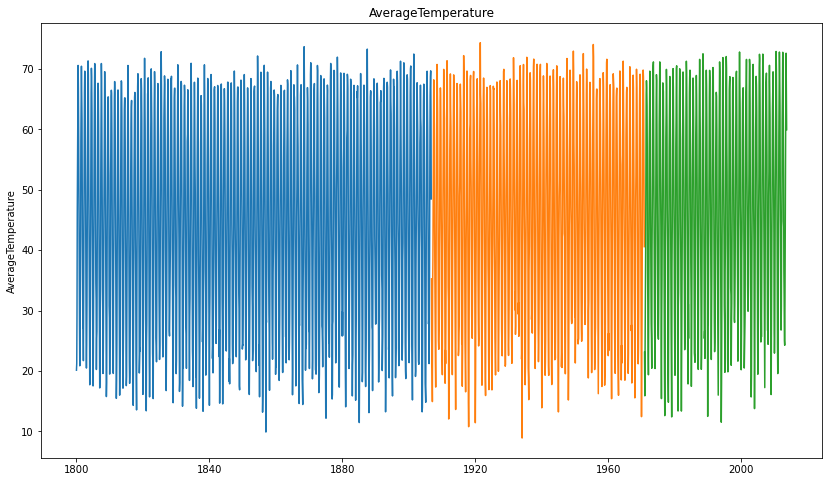

In [24]:
# the data is split in the view into train, validate, and test
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

In [25]:
# create an empty dataframe and set up the environment for modeling
model_df= pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
model_df

,model_type,target_var,rmse


In [26]:
# Set up the environment for modeling
def amodel_df(model_type, target_var):
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return model_df.append(d, ignore_index = True)

In [27]:
# Set up the environment for last observation prediction
temp = train['AverageTemperature'][-1:][0]
yhat_df = pd.DataFrame(
    {'AverageTemperature': [temp]},
    index=validate.index)

yhat_df.head()

,AverageTemperature
dt,
1906-11-01,48.4916
1906-12-01,48.4916
1907-01-01,48.4916
1907-02-01,48.4916
1907-03-01,48.4916


In [28]:
for col in train.columns:
    model_df =amodel_df(model_type = 'last_observed_value', target_var = col)
model_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,18.0


In [29]:
# calculate the simple average
temp2 = round(train['AverageTemperature'].mean(), 2)
yhat_df= pd.DataFrame({'AverageTemperature': [temp2]}, index=validate.index)

In [30]:
for col in train.columns:
    model_df = amodel_df(model_type='simple_average', 
                            target_var = col)
model_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,18.0
1,simple_average,AverageTemperature,17.0


In [31]:
# set up the environment for moving average modeling
periods = [1, 2, 3, 4, 10]

for p in periods: 
    temp3 = round(train['AverageTemperature'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame({'AverageTemperature': [temp3]},
                          index=validate.index)
    model_type = str(p) + '_year_moving_avg'
    for col in train.columns:
        model_df = amodel_df(model_type = model_type,
                                target_var = col)

In [32]:
model_df
# so far the simple_average has the best result

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,18.0
1,simple_average,AverageTemperature,17.0
2,1_year_moving_avg,AverageTemperature,18.0
3,2_year_moving_avg,AverageTemperature,20.0
4,3_year_moving_avg,AverageTemperature,23.0
5,4_year_moving_avg,AverageTemperature,24.0
6,10_year_moving_avg,AverageTemperature,18.0


/opt/homebrew/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


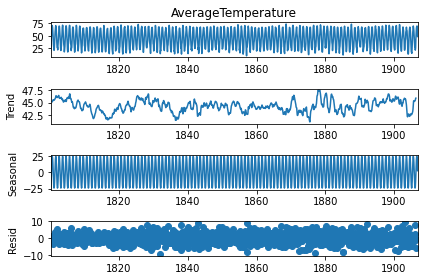

In [33]:
# Setting up the environment for the Holt's Linear Trend
sm.tsa.seasonal_decompose(train[col].resample('M').mean()).plot()
col='AverageTemperature'
model = Holt(train[col], exponential=False, damped=True)
model = model.fit(optimized=True)

In [34]:
yhat_df= model.predict(start = validate.index[0],
                              end = validate.index[-1])
yhat_df[col] = round(yhat_df, 2)

In [35]:
model_df = amodel_df(model_type = 'holts_optimized', 
                            target_var = col)
model_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,18.0
1,simple_average,AverageTemperature,17.0
2,1_year_moving_avg,AverageTemperature,18.0
3,2_year_moving_avg,AverageTemperature,20.0
4,3_year_moving_avg,AverageTemperature,23.0
5,4_year_moving_avg,AverageTemperature,24.0
6,10_year_moving_avg,AverageTemperature,18.0
7,holts_optimized,AverageTemperature,54.0


In [36]:
# environment for previous year model
train.tail(),validate.head(),validate.tail(),test.head()

(            AverageTemperature
 dt                            
 1906-06-01             65.6186
 1906-07-01             68.6894
 1906-08-01             69.6902
 1906-09-01             62.7836
 1906-10-01             48.4916,
             AverageTemperature
 dt                            
 1906-11-01             35.2634
 1906-12-01             21.7670
 1907-01-01             20.4278
 1907-02-01             14.9450
 1907-03-01             33.5048,
             AverageTemperature
 dt                            
 1970-07-01             69.8216
 1970-08-01             68.6732
 1970-09-01             61.6280
 1970-10-01             51.7190
 1970-11-01             40.5860,
             AverageTemperature
 dt                            
 1970-12-01             23.1026
 1971-01-01             15.8972
 1971-02-01             24.0638
 1971-03-01             28.6754
 1971-04-01             40.0766)

In [37]:
# set the environment up
train = climate_df[:'1906']
validate = climate_df['1907']
validatet=climate_df[:'1970']
testt = climate_df['1971']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()

(1284, 1)
(12, 1)
(514, 1)


,AverageTemperature
dt,
1800-01-01,20.1398
1800-02-01,21.2792
1800-03-01,29.2154
1800-04-01,46.2362
1800-05-01,54.7322


In [38]:
# create yhat
yhat_df = train['1906'] + train.diff(12).mean()

In [39]:
# put it into model and get RMSE
model_df = amodel_df(model_type = "previous_year", 
                            target_var = col)
model_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,18.0
1,simple_average,AverageTemperature,17.0
2,1_year_moving_avg,AverageTemperature,18.0
3,2_year_moving_avg,AverageTemperature,20.0
4,3_year_moving_avg,AverageTemperature,23.0
5,4_year_moving_avg,AverageTemperature,24.0
6,10_year_moving_avg,AverageTemperature,18.0
7,holts_optimized,AverageTemperature,54.0
8,previous_year,AverageTemperature,5.0


#### The best model is previous year, which we are going to use for the test

In [40]:
# environment set up for the test
def fmodel_df(model_type, target_var):
    rmse = round(sqrt(mean_squared_error(testt[target_var], yhat_df[target_var])), 0)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return model_df.append(d, ignore_index = True)

In [41]:
# We will use the previous year for this final test
yhat_df = validatet['1970'] + validatet.diff(12).mean()
pd.concat([yhat_df.head(1), validatet.tail(1)])

model_df = fmodel_df(model_type = "previous_year", 
                            target_var = 'AverageTemperature')
model_df

,model_type,target_var,rmse
0,last_observed_value,AverageTemperature,18.0
1,simple_average,AverageTemperature,17.0
2,1_year_moving_avg,AverageTemperature,18.0
3,2_year_moving_avg,AverageTemperature,20.0
4,3_year_moving_avg,AverageTemperature,23.0
5,4_year_moving_avg,AverageTemperature,24.0
6,10_year_moving_avg,AverageTemperature,18.0
7,holts_optimized,AverageTemperature,54.0
8,previous_year,AverageTemperature,5.0
9,previous_year,AverageTemperature,3.0


## Modeling Key takeaway
- This test compared 5 models, and the previous year model is the best model
- The test achieved RMSE 3
- The average temperature has not change that much as recognizable therefore the model will able to use the previous year to predict

# Recommendation, Conclusion, and Next Step
## Recommendation
- The average temperature, year over year is increasing.
- The hypothesis tests proved that the New York year over year is increasing the temperature
- It is believable that we need to start to fight climate change

## Conclusion
- The hypothesis revealed that the New York temperature is raising year over year
- The modeling reveal that the previous year has the best result with 3 RMSE
- The lag reveals that the temperature might decrease in near future on year over year based

## Next Step
- we should increase the scale of the dataset into country or contries
- we should include sea level for comparison
- We should start thinking about recycling